# Plot Malignancy Estimation Results

Code adapted from the following repositories:

* [Kiran model](https://github.com/DIAGNijmegen/bodyct-nodule-malignancy)
* [Thijmen model](https://github.com/DIAGNijmegen/bodyct-lung-malignancy)
* [StackOverflow on right-align legend text](https://stackoverflow.com/questions/7936034/text-alignment-in-a-matplotlib-legend)

In [1]:
import pandas as pd
import os
import numpy as np

import seaborn as sns
sns.set_style("white")
from evalutils.roc import get_bootstrapped_roc_ci_curves
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

%matplotlib inline
import sklearn.metrics as skl_metrics

import utils
from utils import plot_rocs

## Read Data (DLCST results)

In [2]:
## directory where results are
LOCAL_PC = False
root_dir = "/mnt/w" if LOCAL_PC else ""
EXPERIMENT_DIR = f"/data/bodyct/experiments/lung-malignancy-fairness-shaurya"
DLCST_PREDS = f"{EXPERIMENT_DIR}/dlcst"

DLCST_PREDS_LOCAL = "C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results/dlcst"
DLCST_PREDS = DLCST_PREDS_LOCAL ## Comment out if not using Teams backup (aka Chansey is up :)

In [3]:
## Read DLCST results
df_results = pd.read_csv(f"{DLCST_PREDS}/dlcst_thijmen_kiran_sybil_malignancy_estimation_results.csv", header=0)
df_results.head()

PatientID  StudyDate                        SeriesInstanceUID  Age  Sex  \
0          4   20050124  1.2.840.113704.1.111.4964.1106577805.10   55    2   
1         35   20051208  1.2.840.113704.1.111.5776.1134059140.11   56    1   
2         38   20060109  1.2.840.113704.1.111.2004.1136823831.14   62    2   
3         47   20051214  1.2.840.113704.1.111.8148.1134579622.14   57    1   
4         56   20051213  1.2.840.113704.1.111.2744.1134487263.11   64    1   

   FamilyHistoryLungCa  Emphysema  NoduleCountPerScan  sybil_year1  \
0                    0          0                   9     0.021629   
1                    1          1                   2     0.001170   
2                    0          1                   4     0.001784   
3                    0          1                   1     0.003951   
4                    0          1                   3     0.000000   

   sybil_year2  sybil_year3  sybil_year4  sybil_year5  sybil_year6  PanCan2b  \
0     0.038573     0.071919     0.079270     0.095846     0.135681  0.053366   
1     0.002554     0.007835     0.011039     0.018442     0.030460  0.009543   
2     0.003870     0.007835     0.012797     0.019229     0.032957  0.006734   
3     0.015674     0.025373     0.034010     0.040605     0.058852  0.007944   
4     0.001574     0.003791     0.006847     0.010381     0.017287  0.000899   

   Ensemble_Kiran  thijmen_mean  label  
0        0.082652      0.166209      0  
1        0.000408      0.003368      0  
2        0.002702      0.065888      0  
3        0.084158      0.423341      0  
4        0.000013      0.005590      0

In [4]:
len(pd.unique(df_results['SeriesInstanceUID'])), len(pd.unique(df_results['PatientID']))

(599, 599)

In [5]:
df_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PatientID            599 non-null    int64  
 1   StudyDate            599 non-null    int64  
 2   SeriesInstanceUID    599 non-null    object 
 3   Age                  599 non-null    int64  
 4   Sex                  599 non-null    int64  
 5   FamilyHistoryLungCa  599 non-null    int64  
 6   Emphysema            599 non-null    int64  
 7   NoduleCountPerScan   599 non-null    int64  
 8   sybil_year1          599 non-null    float64
 9   sybil_year2          599 non-null    float64
 10  sybil_year3          599 non-null    float64
 11  sybil_year4          599 non-null    float64
 12  sybil_year5          599 non-null    float64
 13  sybil_year6          599 non-null    float64
 14  PanCan2b             599 non-null    float64
 15  Ensemble_Kiran       599 non-null    flo

In [6]:
df_results.describe()

PatientID     StudyDate         Age         Sex  FamilyHistoryLungCa  \
count   599.000000  5.990000e+02  599.000000  599.000000           599.000000   
mean   1883.756260  2.005100e+07   58.397329    1.460768             0.170284   
std    1215.815006  7.593265e+03    4.946103    0.498875             0.376196   
min       4.000000  2.004111e+07   50.000000    1.000000             0.000000   
25%     800.500000  2.005013e+07   54.000000    1.000000             0.000000   
50%    1689.000000  2.005052e+07   58.000000    1.000000             0.000000   
75%    3011.500000  2.005103e+07   62.000000    2.000000             0.000000   
max    4099.000000  2.009122e+07   75.000000    2.000000             1.000000   

        Emphysema  NoduleCountPerScan  sybil_year1  sybil_year2  sybil_year3  \
count  599.000000          599.000000   599.000000   599.000000   599.000000   
mean     0.676127            1.769616     0.025965     0.040542     0.050433   
std      0.468343            1.165421     0.080576     0.104781     0.111505   
min      0.000000            1.000000     0.000000     0.000000     0.000000   
25%      0.000000            1.000000     0.001170     0.002554     0.007835   
50%      1.000000            1.000000     0.001965     0.005733     0.010996   
75%      1.000000            2.000000     0.007145     0.020146     0.029786   
max      1.000000            9.000000     0.838213     0.903660     0.902390   

       sybil_year4  sybil_year5  sybil_year6    PanCan2b  Ensemble_Kiran  \
count   599.000000   599.000000   599.000000  599.000000    5.990000e+02   
mean      0.058651     0.067412     0.089968    0.055902    1.461987e-01   
std       0.115754     0.121409     0.135617    0.118722    2.966031e-01   
min       0.000000     0.000000     0.000000    0.000000    8.820000e-07   
25%       0.012797     0.019229     0.032957    0.002396    2.369950e-04   
50%       0.015721     0.021112     0.035951    0.007804    2.825316e-03   
75%       0.039906     0.051451     0.076318    0.044897    6.282042e-02   
max       0.914693     0.914693     0.914693    0.789437    9.988375e-01   

       thijmen_mean       label  
count    599.000000  599.000000  
mean       0.166094    0.098497  
std        0.241460    0.298235  
min        0.000574    0.000000  
25%        0.011600    0.000000  
50%        0.045436    0.000000  
75%        0.201205    0.000000  
max        0.977596    1.000000

<Axes: xlabel='Age', ylabel='Count'>

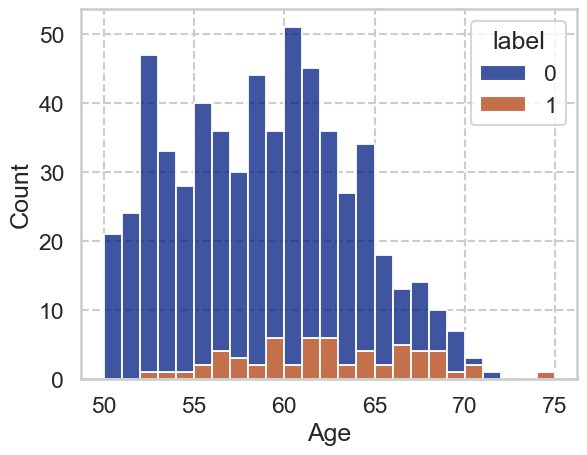

In [7]:
sns.histplot(df_results, x="Age", bins=25, hue="label", multiple='stack')

In [8]:
df_results.query('Age == 70')['label'].value_counts()

label
1    2
0    1
Name: count, dtype: int64

In [9]:
df_malignant = df_results.query('label == 1')
df_malignant.describe()

PatientID     StudyDate        Age        Sex  FamilyHistoryLungCa  \
count    59.000000  5.900000e+01  59.000000  59.000000            59.000000   
mean   2226.067797  2.006203e+07  62.000000   1.457627             0.271186   
std    1146.619783  1.472711e+04   4.856563   0.502478             0.448388   
min      62.000000  2.004112e+07  52.000000   1.000000             0.000000   
25%    1303.500000  2.005072e+07  59.000000   1.000000             0.000000   
50%    2218.000000  2.005121e+07  62.000000   1.000000             0.000000   
75%    3300.500000  2.007056e+07  66.000000   2.000000             1.000000   
max    4032.000000  2.009122e+07  75.000000   2.000000             1.000000   

       Emphysema  NoduleCountPerScan  sybil_year1  sybil_year2  sybil_year3  \
count  59.000000           59.000000    59.000000    59.000000    59.000000   
mean    0.745763            1.711864     0.145046     0.200687     0.222831   
std     0.439169            1.175187     0.179729     0.218469     0.226036   
min     0.000000            1.000000     0.000421     0.002048     0.006331   
25%     0.500000            1.000000     0.010938     0.023848     0.040202   
50%     1.000000            1.000000     0.084456     0.143517     0.172521   
75%     1.000000            2.000000     0.215565     0.306710     0.306925   
max     1.000000            7.000000     0.838213     0.903660     0.902390   

       sybil_year4  sybil_year5  sybil_year6   PanCan2b  Ensemble_Kiran  \
count    59.000000    59.000000    59.000000  59.000000       59.000000   
mean      0.240233     0.258463     0.307859   0.221539        0.698916   
std       0.228718     0.236872     0.248971   0.201549        0.336146   
min       0.010185     0.014170     0.022664   0.003140        0.000115   
25%       0.056078     0.068311     0.104660   0.050493        0.528134   
50%       0.197799     0.211975     0.276596   0.167578        0.833620   
75%       0.337119     0.365862     0.415215   0.296643        0.971705   
max       0.914693     0.914693     0.914693   0.789437        0.998838   

       thijmen_mean  label  
count     59.000000   59.0  
mean       0.616382    1.0  
std        0.273137    0.0  
min        0.007771    1.0  
25%        0.474855    1.0  
50%        0.678868    1.0  
75%        0.837449    1.0  
max        0.977596    1.0

### Define DLCST Splits
DataFrame queries for subsets. Can use this for plots and whatnot.

In [21]:
SPLIT_QUERIES = {
    "Sex": {
        "male": 'Sex == 1',
        "female": 'Sex == 2' 
    },
    "FamilyHistoryLungCa": {
        "no": 'FamilyHistoryLungCa == 0',
        "yes": 'FamilyHistoryLungCa == 1' 
    },
    "Emphysema": {
        "no": 'Emphysema == 0',
        "yes": 'Emphysema == 1' 
    },
    "Age": {
        "50-62": '50 <= Age < 62',
        "62+": '62 <= Age', 
    },
    "NoduleCountPerScan": {
        "1": 'NoduleCountPerScan == 1',
        ">1": 'NoduleCountPerScan > 1' 
    }
}

In [ ]:
def get_split_dfs(df, split_by="SEX", printinfo=True):
    subset_dfs = {}
    for (split, query) in SPLIT_QUERIES[split_by].items():
        subset_dfs[split] = df.query(query)
        
        if printinfo:
            mal_count = len(subset_dfs[split].query('label == 1'))
            mal_percent = 100 * (mal_count / len(subset_dfs[split]))
            print(f"{split}, n={len(subset_dfs[split])}, {mal_count} malignant ({mal_percent:.2f}%)")
    
    return subset_dfs

## Compare ROCs across models

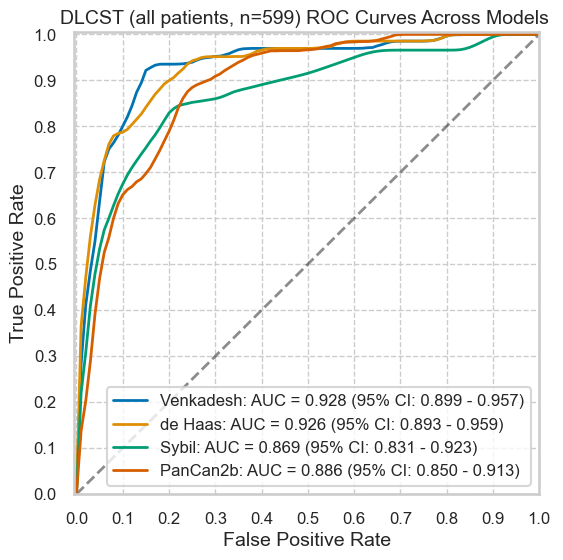

In [12]:
MODEL_TO_COL = {
    "Venkadesh": "Ensemble_Kiran",
    "de Haas": "thijmen_mean",
    "Sybil": "sybil_year1",
    "PanCan2b": "PanCan2b",
}

def rocs_models(df, true_col='label', models=["Venkadesh", "de Haas", "Sybil", "PanCan2b"], dataset_label="DLCST", subset_label="all", imgpath=None, plot_ci=False):
    rocs = {}
    for m in models:
        rocs[m] = get_bootstrapped_roc_ci_curves(df[MODEL_TO_COL[m]].values, df[true_col].values)
    
    plot_rocs(rocs, f'{dataset_label} ({subset_label} patients, n={len(df)}) ROC Curves Across Models ', imgpath, plot_ci)

rocs_models(df_results)

## Plot Splits for Same Model

In [15]:
def rocs_splits(df, cat="sex", dataset_label="DLCST", true_col='label', models=MODEL_TO_COL, imgpath=None, plot_ci=False):
    groups = get_split_dfs(df, cat, printinfo=False).items()
    display(Markdown(f"#### {cat}"))
    df_catinfo, skips = utils.info_by_splits(groups, 2)
    display(df_catinfo)
    # plot_roc = (0 not in df_catinfo['num_mal']) and (len() not in df_catinfo['pct_mal'])

    rocs = {}
    for m in models:
        rocs[m], df_perf = utils.perf_by_splits(groups, pred_col=MODEL_TO_COL[m])
        print(m)
        display(df_perf)

    do_sigtest = (len(df_catinfo) - len(skips)) == 2
    bin_sigtest_results = {}

    fig, ax = plt.subplots(1, len(models), figsize=(6.5 * len(models) - 0.5, 6.5))
    fig.suptitle(f"Model Performance Split By {cat}")
    for i, m in enumerate(models):
        title_str = m
        if do_sigtest:
            z, p = utils.hanley_mcneil_sigtest(df_catinfo, skips, rocs[m])
            title_str = f"{m}\n(z={z:.6f}, p={p:.6f})"
            bin_sigtest_results[m] = {"z": z, "p": p}

        utils.ax_rocs(ax[i], rocs[m], title=title_str)
    plt.show()

    df_sigtest_results = None
    if do_sigtest:
        df_sigtest_results = pd.DataFrame(bin_sigtest_results)
    
    display(df_sigtest_results)

    return df_sigtest_results

    # rocs = {}
    # rocs['all'] = get_bootstrapped_roc_ci_curves(df[MODEL_TO_COL[model]].values, df[true_col].values)   
    # for split, df_subset in subset_dfs.items():
    #     rocs[split] = get_bootstrapped_roc_ci_curves(df_subset[MODEL_TO_COL[model]].values, df_subset[true_col].values)
    
    # plot_rocs(rocs, f'{dataset_label} (split by {split_by}) ROC Curves for {model} Model', imgpath, plot_ci)

#### sex

num        pct  num_mal   pct_mal
male    323  53.923205       32  9.907121
female  276  46.076795       27  9.782609

Venkadesh


num  tp  fp   tn  fn      tpr       fpr      fnr       tnr       ppv  \
male    323  29  62  229   3  0.90625  0.213058  0.09375  0.786942  0.318681   
female  276  27  83  166   0  1.00000  0.333333  0.00000  0.666667  0.245455   

             npv       fdr       for       acc         j        f1       mcc  
male    0.987069  0.681319  0.012931  0.798762  0.693192  0.471545  0.460373  
female  1.000000  0.754545  0.000000  0.699275  0.666667  0.394161  0.404520

de Haas


num  tp   fp   tn  fn      tpr       fpr      fnr       tnr       ppv  \
male    323  31  190  101   1  0.96875  0.652921  0.03125  0.347079  0.140271   
female  276  27  174   75   0  1.00000  0.698795  0.00000  0.301205  0.134328   

             npv       fdr       for       acc         j        f1       mcc  
male    0.990196  0.859729  0.009804  0.408669  0.315829  0.245059  0.202991  
female  1.000000  0.865672  0.000000  0.369565  0.301205  0.236842  0.201148

Sybil


num  tp  fp   tn  fn      tpr       fpr      fnr       tnr       ppv  \
male    323  24  24  267   8  0.75000  0.082474  0.25000  0.917526  0.500000   
female  276  17  35  214  10  0.62963  0.140562  0.37037  0.859438  0.326923   

             npv       fdr       for       acc         j       f1       mcc  
male    0.970909  0.500000  0.029091  0.900929  0.667526  0.60000  0.560664  
female  0.955357  0.673077  0.044643  0.836957  0.489067  0.43038  0.371556

PanCan2b


num  tp   fp   tn  fn       tpr       fpr       fnr       tnr  \
male    323  29   78  213   3  0.906250  0.268041  0.093750  0.731959   
female  276  26  109  140   1  0.962963  0.437751  0.037037  0.562249   

             ppv       npv       fdr       for       acc         j        f1  \
male    0.271028  0.986111  0.728972  0.013889  0.749226  0.638209  0.417266   
female  0.192593  0.992908  0.807407  0.007092  0.601449  0.525212  0.320988   

             mcc  
male    0.405103  
female  0.312133

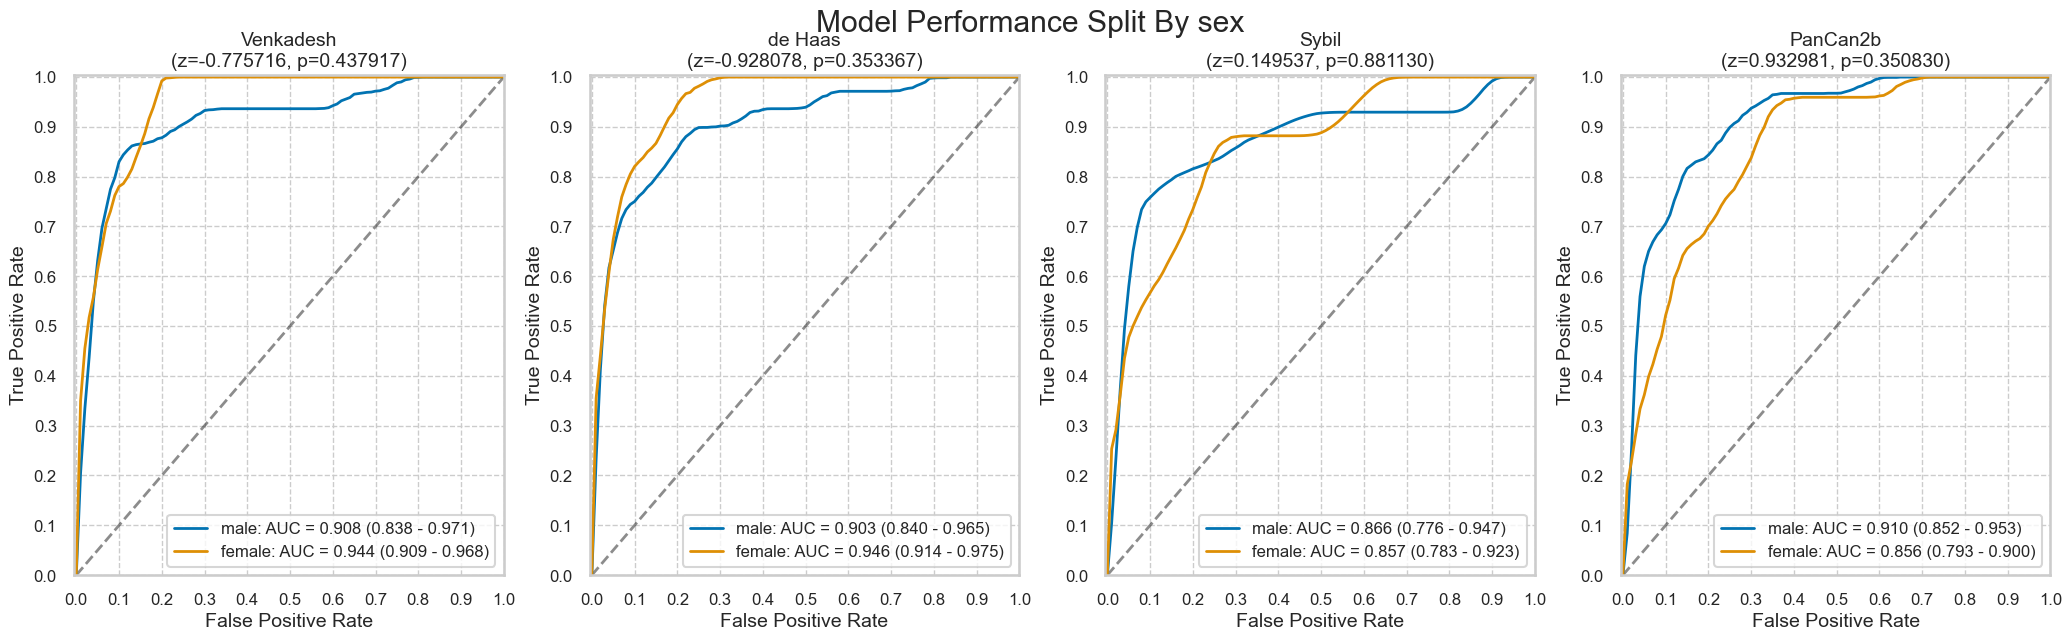

Venkadesh   de Haas     Sybil  PanCan2b
z  -0.775716 -0.928078  0.149537  0.932981
p   0.437917  0.353367  0.881130  0.350830

#### family history

num        pct  num_mal    pct_mal
no   497  82.971619       43   8.651911
yes  102  17.028381       16  15.686275

Venkadesh


num  tp   fp   tn  fn       tpr       fpr       fnr       tnr       ppv  \
no   497  40  119  335   3  0.930233  0.262115  0.069767  0.737885  0.251572   
yes  102  16   26   60   0  1.000000  0.302326  0.000000  0.697674  0.380952   

          npv       fdr       for       acc         j        f1       mcc  
no   0.991124  0.748428  0.008876  0.754527  0.668118  0.396040  0.402678  
yes  1.000000  0.619048  0.000000  0.745098  0.697674  0.551724  0.515539

de Haas


num  tp   fp   tn  fn       tpr       fpr       fnr       tnr       ppv  \
no   497  42  308  146   1  0.976744  0.678414  0.023256  0.321586  0.120000   
yes  102  16   56   30   0  1.000000  0.651163  0.000000  0.348837  0.222222   

          npv       fdr       for      acc         j        f1       mcc  
no   0.993197  0.880000  0.006803  0.37827  0.298330  0.213740  0.183767  
yes  1.000000  0.777778  0.000000  0.45098  0.348837  0.363636  0.278423

Sybil


num  tp  fp   tn  fn       tpr       fpr       fnr       tnr       ppv  \
no   497  29  48  406  14  0.674419  0.105727  0.325581  0.894273  0.376623   
yes  102  12  11   75   4  0.750000  0.127907  0.250000  0.872093  0.521739   

          npv       fdr       for       acc         j        f1       mcc  
no   0.966667  0.623377  0.033333  0.875252  0.568692  0.483333  0.441844  
yes  0.949367  0.478261  0.050633  0.852941  0.622093  0.615385  0.541361

PanCan2b


num  tp   fp   tn  fn       tpr       fpr       fnr       tnr       ppv  \
no   497  39  154  300   4  0.906977  0.339207  0.093023  0.660793  0.202073   
yes  102  16   33   53   0  1.000000  0.383721  0.000000  0.616279  0.326531   

          npv       fdr       for       acc         j        f1       mcc  
no   0.986842  0.797927  0.013158  0.682093  0.567770  0.330508  0.327506  
yes  1.000000  0.673469  0.000000  0.676471  0.616279  0.492308  0.448591

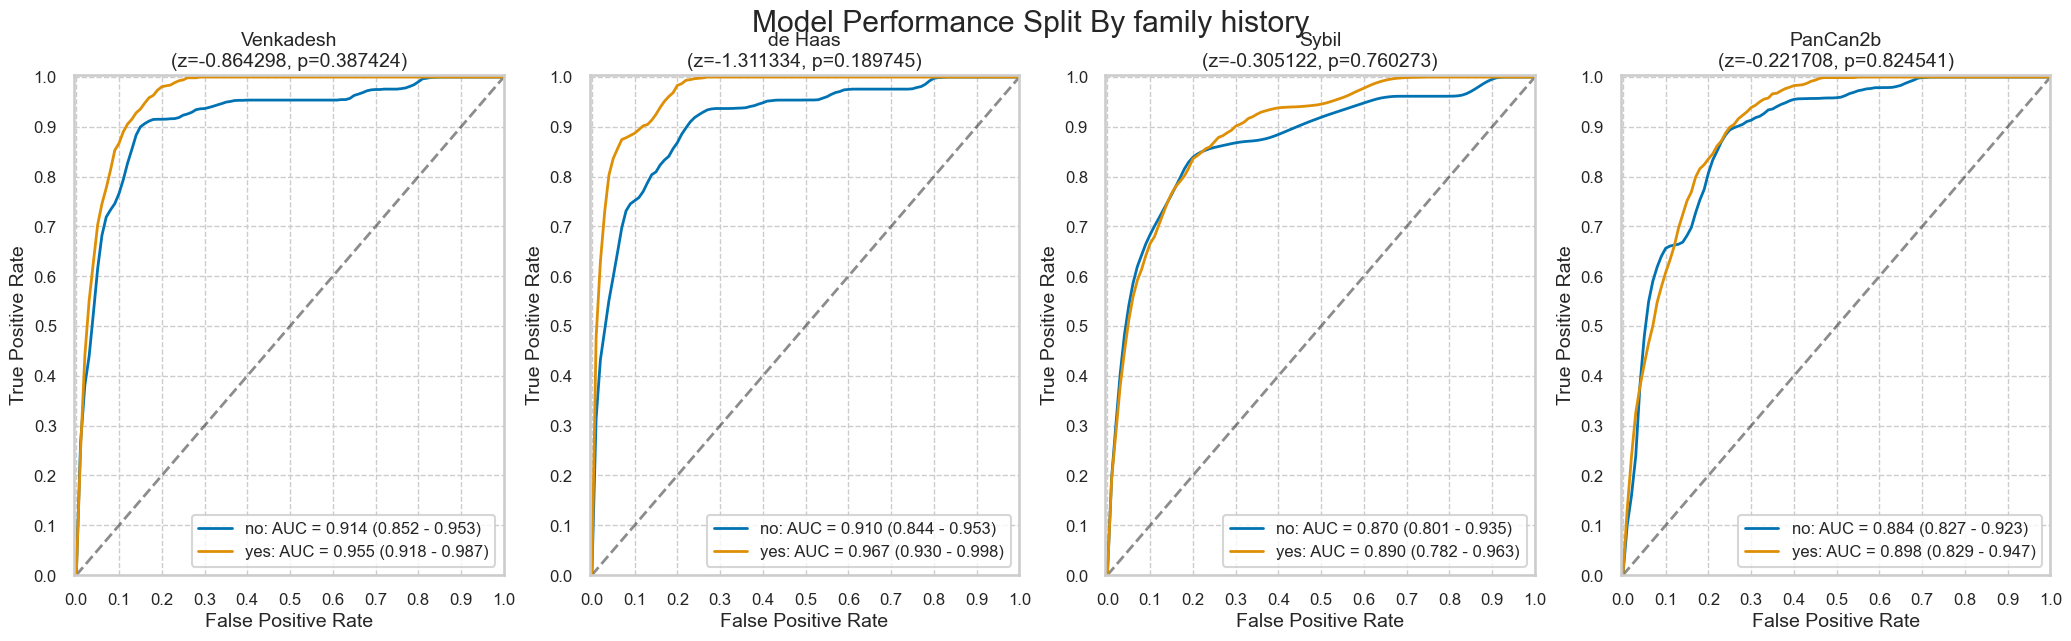

Venkadesh   de Haas     Sybil  PanCan2b
z  -0.864298 -1.311334 -0.305122 -0.221708
p   0.387424  0.189745  0.760273  0.824541

#### emphysema

num        pct  num_mal    pct_mal
no   194  32.387312       15   7.731959
yes  405  67.612688       44  10.864198

Venkadesh


num  tp   fp   tn  fn       tpr       fpr       fnr       tnr       ppv  \
no   194  15   37  142   0  1.000000  0.206704  0.000000  0.793296  0.288462   
yes  405  41  108  253   3  0.931818  0.299169  0.068182  0.700831  0.275168   

          npv       fdr       for       acc         j        f1       mcc  
no   1.000000  0.711538  0.000000  0.809278  0.793296  0.447761  0.478367  
yes  0.988281  0.724832  0.011719  0.725926  0.632649  0.424870  0.408253

de Haas


num  tp   fp   tn  fn       tpr       fpr       fnr       tnr       ppv  \
no   194  15  112   67   0  1.000000  0.625698  0.000000  0.374302  0.118110   
yes  405  43  252  109   1  0.977273  0.698061  0.022727  0.301939  0.145763   

          npv       fdr       for       acc         j        f1       mcc  
no   1.000000  0.881890  0.000000  0.422680  0.374302  0.211268  0.210259  
yes  0.990909  0.854237  0.009091  0.375309  0.279212  0.253687  0.195347

Sybil


num  tp  fp   tn  fn       tpr       fpr       fnr       tnr       ppv  \
no   194  10  12  167   5  0.666667  0.067039  0.333333  0.932961  0.454545   
yes  405  31  47  314  13  0.704545  0.130194  0.295455  0.869806  0.397436   

          npv       fdr       for       acc         j        f1       mcc  
no   0.970930  0.545455  0.029070  0.912371  0.599628  0.540541  0.505101  
yes  0.960245  0.602564  0.039755  0.851852  0.574352  0.508197  0.453249

PanCan2b


num  tp   fp   tn  fn       tpr       fpr       fnr       tnr      ppv  \
no   194  15   45  134   0  1.000000  0.251397  0.000000  0.748603  0.25000   
yes  405  40  142  219   4  0.909091  0.393352  0.090909  0.606648  0.21978   

          npv      fdr       for       acc         j        f1       mcc  
no   1.000000  0.75000  0.000000  0.768041  0.748603  0.400000  0.432609  
yes  0.982063  0.78022  0.017937  0.639506  0.515739  0.353982  0.322643

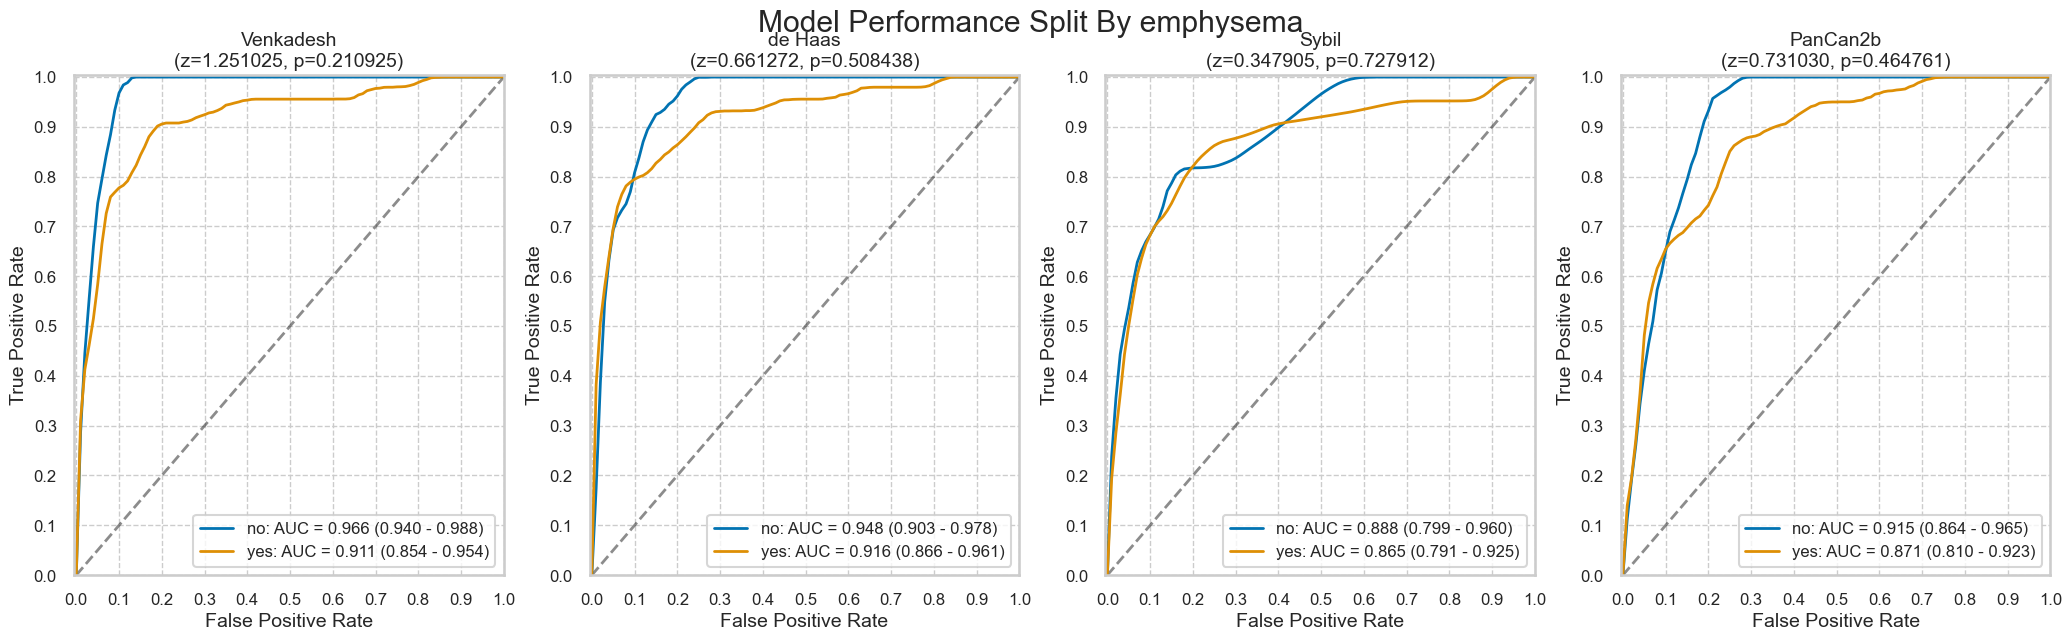

Venkadesh   de Haas     Sybil  PanCan2b
z   1.251025  0.661272  0.347905  0.731030
p   0.210925  0.508438  0.727912  0.464761

#### age

num        pct  num_mal    pct_mal
50-62  435  72.621035       28   6.436782
62+    164  27.378965       31  18.902439

Venkadesh


num  tp   fp   tn  fn       tpr       fpr       fnr       tnr  \
50-62  435  27  105  302   1  0.964286  0.257985  0.035714  0.742015   
62+    164  29   40   93   2  0.935484  0.300752  0.064516  0.699248   

            ppv       npv       fdr       for       acc         j      f1  \
50-62  0.204545  0.996700  0.795455  0.003300  0.756322  0.706300  0.3375   
62+    0.420290  0.978947  0.579710  0.021053  0.743902  0.634732  0.5800   

            mcc  
50-62  0.377014  
62+    0.503397

de Haas


num  tp   fp   tn  fn       tpr       fpr       fnr       tnr  \
50-62  435  27  271  136   1  0.964286  0.665848  0.035714  0.334152   
62+    164  31   93   40   0  1.000000  0.699248  0.000000  0.300752   

            ppv       npv       fdr       for       acc         j        f1  \
50-62  0.090604  0.992701  0.909396  0.007299  0.374713  0.298438  0.165644   
62+    0.250000  1.000000  0.750000  0.000000  0.432927  0.300752  0.400000   

            mcc  
50-62  0.157675  
62+    0.274204

Sybil


num  tp  fp   tn  fn       tpr       fpr       fnr       tnr       ppv  \
50-62  435  18  39  368  10  0.642857  0.095823  0.357143  0.904177  0.315789   
62+    164  23  20  113   8  0.741935  0.150376  0.258065  0.849624  0.534884   

            npv       fdr       for       acc         j        f1       mcc  
50-62  0.973545  0.684211  0.026455  0.887356  0.547034  0.423529  0.397839  
62+    0.933884  0.465116  0.066116  0.829268  0.591560  0.621622  0.526597

PanCan2b


num  tp   fp   tn  fn       tpr       fpr       fnr       tnr  \
50-62  435  27  134  273   1  0.964286  0.329238  0.035714  0.670762   
62+    164  28   53   80   3  0.903226  0.398496  0.096774  0.601504   

            ppv       npv       fdr       for       acc         j        f1  \
50-62  0.167702  0.996350  0.832298  0.003650  0.689655  0.635047  0.285714   
62+    0.345679  0.963855  0.654321  0.036145  0.658537  0.504730  0.500000   

            mcc  
50-62  0.322771  
62+    0.395261

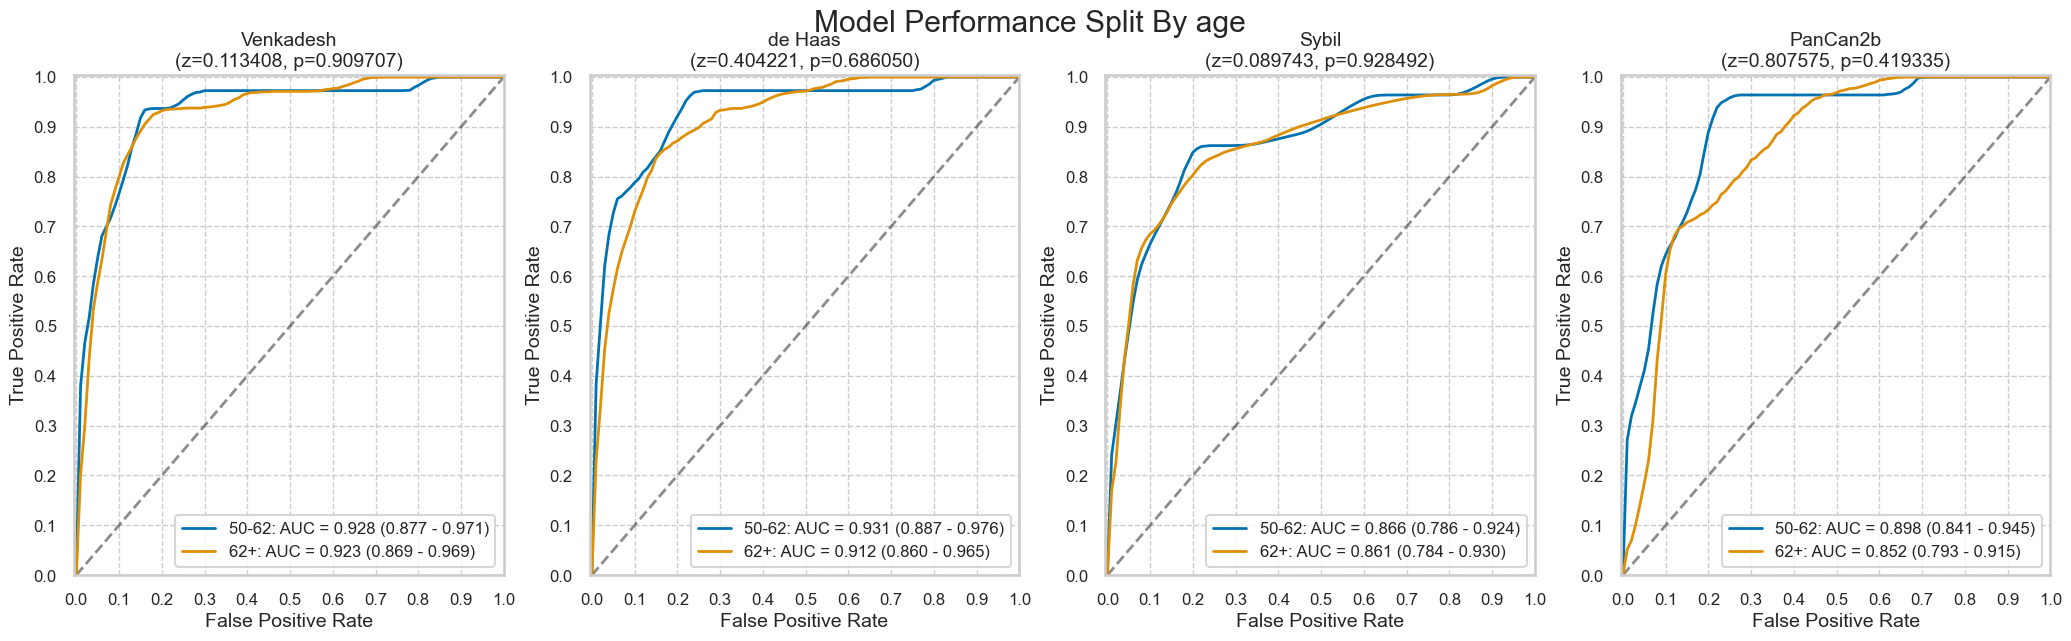

Venkadesh   de Haas     Sybil  PanCan2b
z   0.113408  0.404221  0.089743  0.807575
p   0.909707  0.686050  0.928492  0.419335

#### nodule count

num        pct  num_mal    pct_mal
1   333  55.592654       35  10.510511
>1  266  44.407346       24   9.022556

Venkadesh


num  tp  fp   tn  fn       tpr       fpr       fnr       tnr       ppv  \
1   333  33  67  231   2  0.942857  0.224832  0.057143  0.775168  0.330000   
>1  266  23  78  164   1  0.958333  0.322314  0.041667  0.677686  0.227723   

         npv       fdr       for       acc         j        f1       mcc  
1   0.991416  0.670000  0.008584  0.792793  0.718025  0.488889  0.480401  
>1  0.993939  0.772277  0.006061  0.703008  0.636019  0.368000  0.375475

de Haas


num  tp   fp   tn  fn       tpr       fpr       fnr       tnr       ppv  \
1   333  34  195  103   1  0.971429  0.654362  0.028571  0.345638  0.148472   
>1  266  24  169   73   0  1.000000  0.698347  0.000000  0.301653  0.124352   

         npv       fdr       for       acc         j        f1       mcc  
1   0.990385  0.851528  0.009615  0.411411  0.317066  0.257576  0.209825  
>1  1.000000  0.875648  0.000000  0.364662  0.301653  0.221198  0.193678

Sybil


num  tp  fp   tn  fn       tpr       fpr       fnr       tnr       ppv  \
1   333  27  26  272   8  0.771429  0.087248  0.228571  0.912752  0.509434   
>1  266  14  33  209  10  0.583333  0.136364  0.416667  0.863636  0.297872   

         npv       fdr       for       acc        j        f1       mcc  
1   0.971429  0.490566  0.028571  0.897898  0.68418  0.613636  0.573582  
>1  0.954338  0.702128  0.045662  0.838346  0.44697  0.394366  0.335753

PanCan2b


num  tp  fp   tn  fn       tpr       fpr       fnr       tnr       ppv  \
1   333  34  98  200   1  0.971429  0.328859  0.028571  0.671141  0.257576   
>1  266  21  89  153   3  0.875000  0.367769  0.125000  0.632231  0.190909   

         npv       fdr       for       acc         j        f1       mcc  
1   0.995025  0.742424  0.004975  0.702703  0.642570  0.407186  0.402881  
>1  0.980769  0.809091  0.019231  0.654135  0.507231  0.313433  0.295094

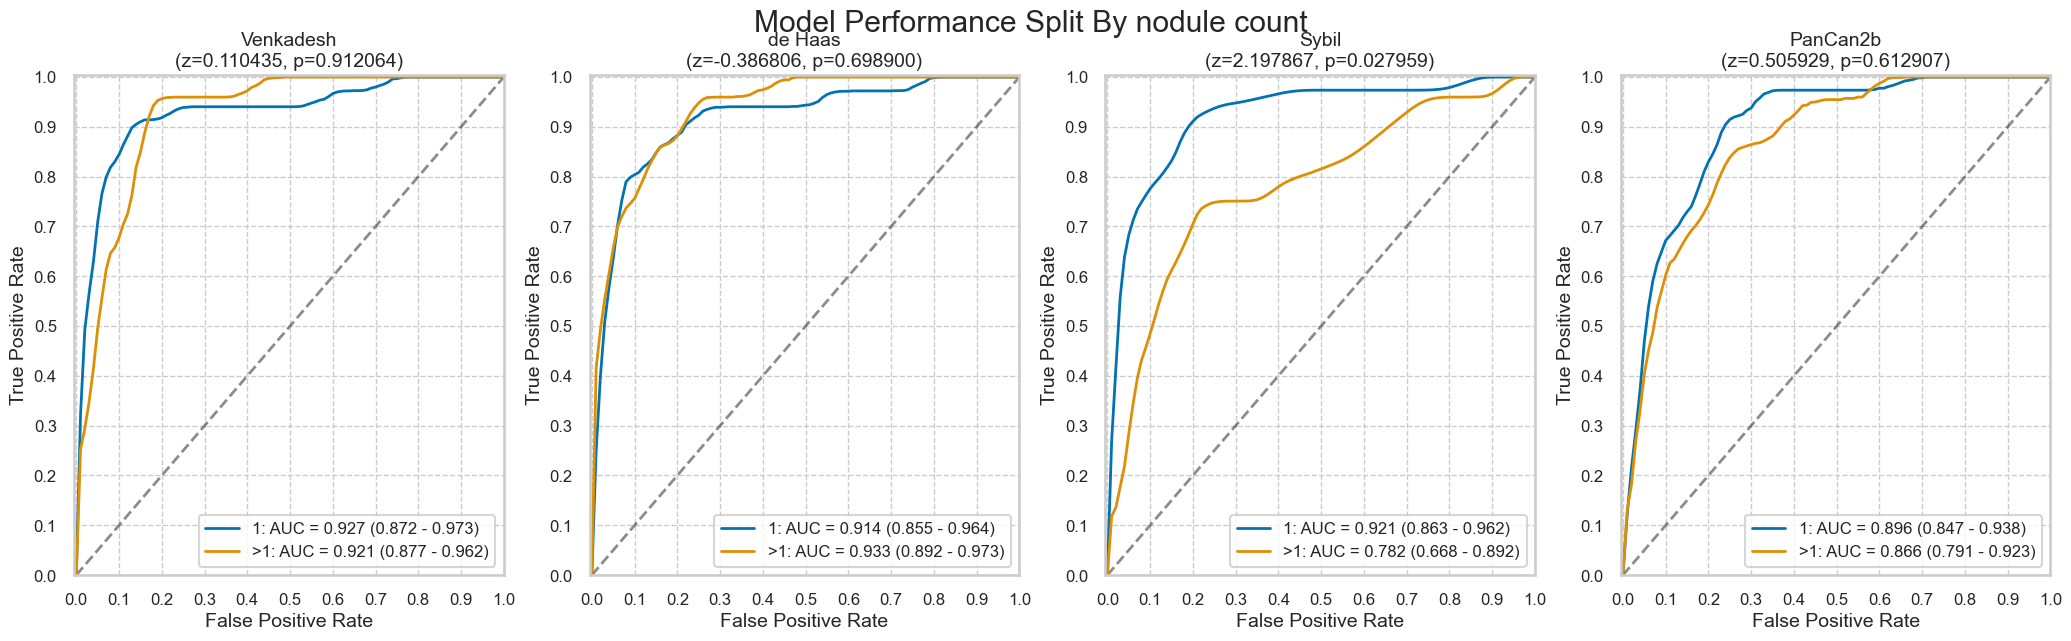

Venkadesh   de Haas     Sybil  PanCan2b
z   0.110435 -0.386806  2.197867  0.505929
p   0.912064  0.698900  0.027959  0.612907

In [16]:
for q in SPLIT_QUERIES:
    rocs_splits(df_results, q)

## Intersectional

In [26]:
SPLIT_CAT = 'Sex'
split_groups = get_split_dfs(df_results, SPLIT_CAT)

male, n=323, 32 malignant (9.91%)
female, n=276, 27 malignant (9.78%)


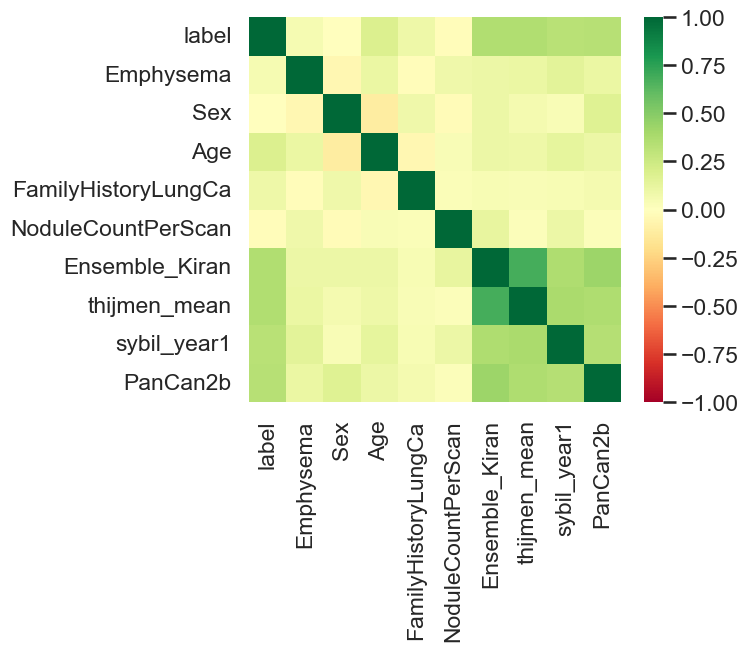

In [32]:
cols_list = list(set(['Age','Sex','FamilyHistoryLungCa','Emphysema','NoduleCountPerScan'] + [SPLIT_CAT, 'label'])) + list(MODEL_TO_COL.values())
correlations = df_results[cols_list].corr(method='kendall').round(4)
plt.figure(figsize=(len(cols_list) * 0.6, len(cols_list) * 0.5))
sns.heatmap(correlations.loc[cols_list, cols_list], cmap='RdYlGn', vmin=-1, vmax=1)
plt.show()

##### Sex = male

#### FamilyHistoryLungCa

num        pct  num_mal    pct_mal
no   277  85.758514       26   9.386282
yes   46  14.241486        6  13.043478

Venkadesh


num  tp  fp   tn  fn       tpr       fpr       fnr       tnr       ppv  \
no   277  23  53  198   3  0.884615  0.211155  0.115385  0.788845  0.302632   
yes   46   6   9   31   0  1.000000  0.225000  0.000000  0.775000  0.400000   

          npv       fdr       for       acc        j        f1       mcc  
no   0.985075  0.697368  0.014925  0.797834  0.67346  0.450980  0.440180  
yes  1.000000  0.600000  0.000000  0.804348  0.77500  0.571429  0.556776

de Haas


num  tp   fp  tn  fn       tpr       fpr       fnr       tnr       ppv  \
no   277  25  164  87   1  0.961538  0.653386  0.038462  0.346614  0.132275   
yes   46   6   26  14   0  1.000000  0.650000  0.000000  0.350000  0.187500   

          npv       fdr       for       acc         j        f1       mcc  
no   0.988636  0.867725  0.011364  0.404332  0.308152  0.232558  0.193026  
yes  1.000000  0.812500  0.000000  0.434783  0.350000  0.315789  0.256174

Sybil


num  tp  fp   tn  fn       tpr       fpr       fnr       tnr       ppv  \
no   277  19  20  231   7  0.730769  0.079681  0.269231  0.920319  0.487179   
yes   46   5   4   36   1  0.833333  0.100000  0.166667  0.900000  0.555556   

          npv       fdr       for       acc         j        f1       mcc  
no   0.970588  0.512821  0.029412  0.902527  0.651088  0.584615  0.545937  
yes  0.972973  0.444444  0.027027  0.891304  0.733333  0.666667  0.622565

PanCan2b


num  tp  fp   tn  fn       tpr       fpr       fnr       tnr       ppv  \
no   277  23  67  184   3  0.884615  0.266932  0.115385  0.733068  0.255556   
yes   46   6  11   29   0  1.000000  0.275000  0.000000  0.725000  0.352941   

          npv       fdr       for       acc         j        f1       mcc  
no   0.983957  0.744444  0.016043  0.747292  0.617683  0.396552  0.384634  
yes  1.000000  0.647059  0.000000  0.760870  0.725000  0.521739  0.505848

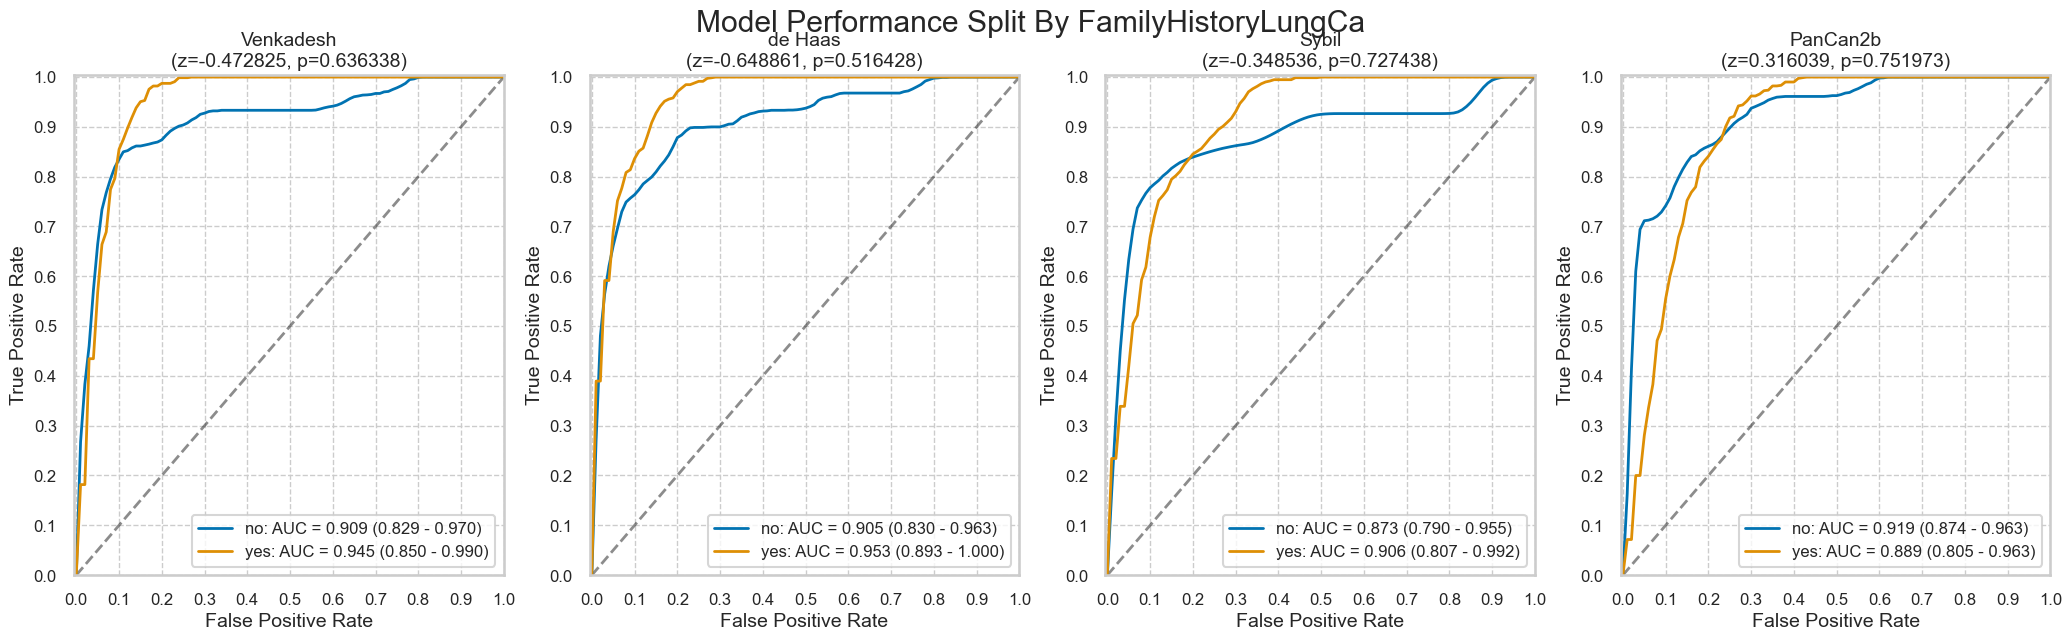

Venkadesh   de Haas     Sybil  PanCan2b
z  -0.472825 -0.648861 -0.348536  0.316039
p   0.636338  0.516428  0.727438  0.751973

##### Sex = female

#### FamilyHistoryLungCa

num        pct  num_mal    pct_mal
no   220  79.710145       17   7.727273
yes   56  20.289855       10  17.857143

Venkadesh


num  tp  fp   tn  fn  tpr       fpr  fnr       tnr       ppv  npv  \
no   220  17  66  137   0  1.0  0.325123  0.0  0.674877  0.204819  1.0   
yes   56  10  17   29   0  1.0  0.369565  0.0  0.630435  0.370370  1.0   

          fdr  for       acc         j        f1       mcc  
no   0.795181  0.0  0.700000  0.674877  0.340000  0.371790  
yes  0.629630  0.0  0.696429  0.630435  0.540541  0.483213

de Haas


num  tp   fp  tn  fn  tpr       fpr  fnr       tnr      ppv  npv  \
no   220  17  144  59   0  1.0  0.709360  0.0  0.290640  0.10559  1.0   
yes   56  10   30  16   0  1.0  0.652174  0.0  0.347826  0.25000  1.0   

         fdr  for       acc         j        f1       mcc  
no   0.89441  0.0  0.345455  0.290640  0.191011  0.175182  
yes  0.75000  0.0  0.464286  0.347826  0.400000  0.294884

Sybil


num  tp  fp   tn  fn       tpr       fpr       fnr       tnr       ppv  \
no   220  10  28  175   7  0.588235  0.137931  0.411765  0.862069  0.263158   
yes   56   7   7   39   3  0.700000  0.152174  0.300000  0.847826  0.500000   

          npv       fdr       for       acc         j        f1       mcc  
no   0.961538  0.736842  0.038462  0.840909  0.450304  0.363636  0.318091  
yes  0.928571  0.500000  0.071429  0.821429  0.547826  0.583333  0.484544

PanCan2b


num  tp  fp   tn  fn       tpr       fpr       fnr       tnr      ppv  \
no   220  16  87  116   1  0.941176  0.428571  0.058824  0.571429  0.15534   
yes   56  10  22   24   0  1.000000  0.478261  0.000000  0.521739  0.31250   

          npv      fdr       for       acc         j        f1       mcc  
no   0.991453  0.84466  0.008547  0.600000  0.512605  0.266667  0.274311  
yes  1.000000  0.68750  0.000000  0.607143  0.521739  0.476190  0.403786

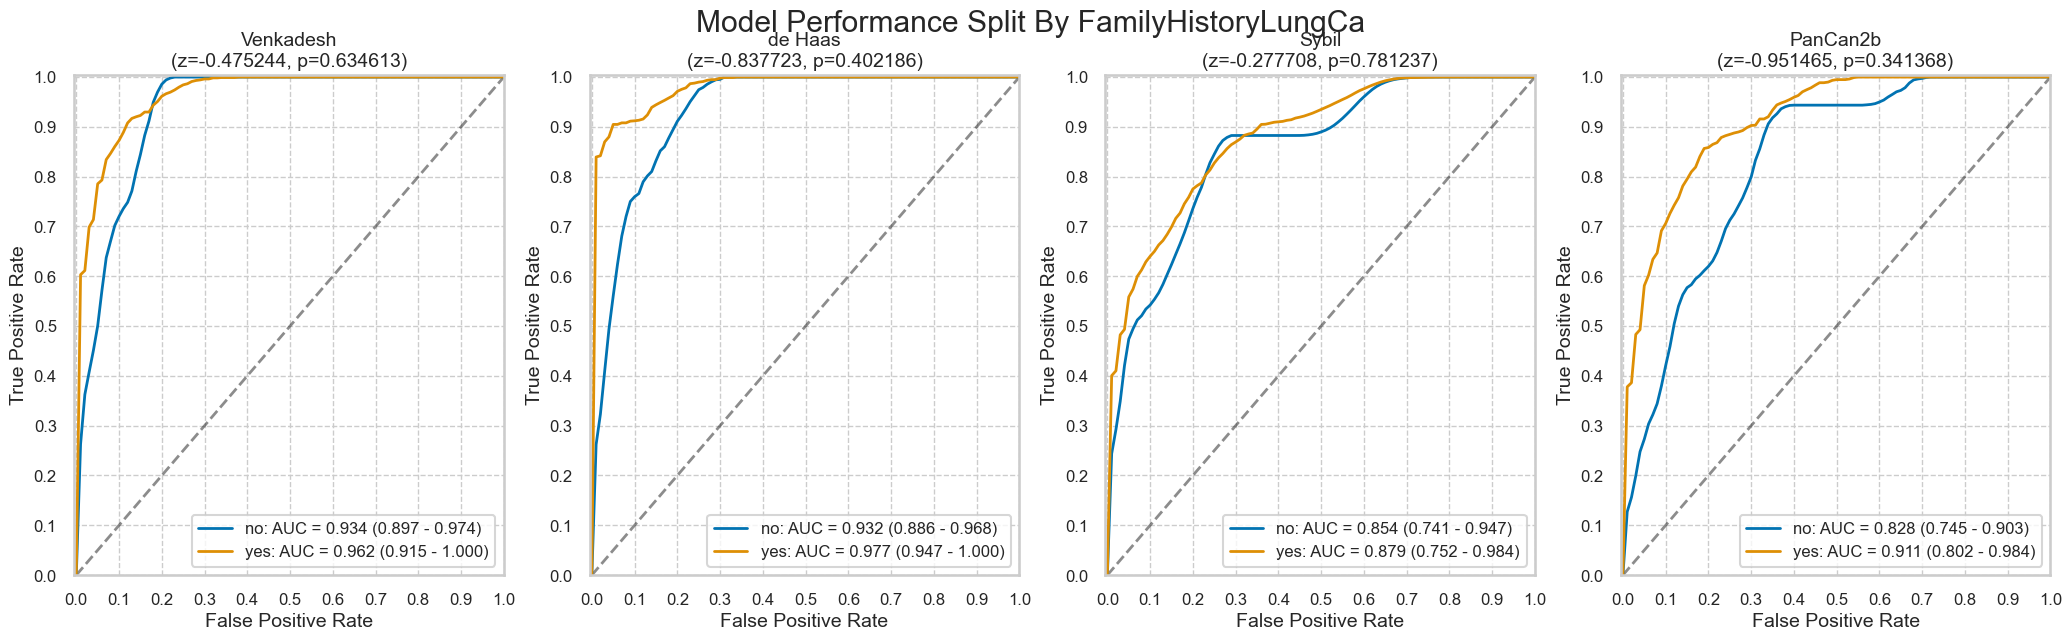

Venkadesh   de Haas     Sybil  PanCan2b
z  -0.475244 -0.837723 -0.277708 -0.951465
p   0.634613  0.402186  0.781237  0.341368

##### Sex = male

#### Emphysema

num       pct  num_mal    pct_mal
no    97  30.03096        4   4.123711
yes  226  69.96904       28  12.389381

Venkadesh


num  tp  fp   tn  fn       tpr       fpr       fnr       tnr       ppv  \
no    97   4  15   78   0  1.000000  0.161290  0.000000  0.838710  0.210526   
yes  226  25  47  151   3  0.892857  0.237374  0.107143  0.762626  0.347222   

          npv       fdr       for       acc         j        f1       mcc  
no   1.000000  0.789474  0.000000  0.845361  0.838710  0.347826  0.420203  
yes  0.980519  0.652778  0.019481  0.778761  0.655483  0.500000  0.463497

de Haas


num  tp   fp  tn  fn       tpr       fpr       fnr       tnr       ppv  \
no    97   4   55  38   0  1.000000  0.591398  0.000000  0.408602  0.067797   
yes  226  27  135  63   1  0.964286  0.681818  0.035714  0.318182  0.166667   

          npv       fdr       for      acc         j        f1       mcc  
no   1.000000  0.932203  0.000000  0.43299  0.408602  0.126984  0.166439  
yes  0.984375  0.833333  0.015625  0.39823  0.282468  0.284211  0.206554

Sybil


num  tp  fp   tn  fn   tpr       fpr   fnr       tnr       ppv       npv  \
no    97   3   6   87   1  0.75  0.064516  0.25  0.935484  0.333333  0.988636   
yes  226  21  18  180   7  0.75  0.090909  0.25  0.909091  0.538462  0.962567   

          fdr       for       acc         j        f1       mcc  
no   0.666667  0.011364  0.927835  0.685484  0.461538  0.469793  
yes  0.461538  0.037433  0.889381  0.659091  0.626866  0.574651

PanCan2b


num  tp  fp   tn  fn       tpr       fpr       fnr       tnr       ppv  \
no    97   4  17   76   0  1.000000  0.182796  0.000000  0.817204  0.190476   
yes  226  25  61  137   3  0.892857  0.308081  0.107143  0.691919  0.290698   

          npv       fdr       for       acc         j        f1       mcc  
no   1.000000  0.809524  0.000000  0.824742  0.817204  0.320000  0.394535  
yes  0.978571  0.709302  0.021429  0.716814  0.584776  0.438596  0.396815

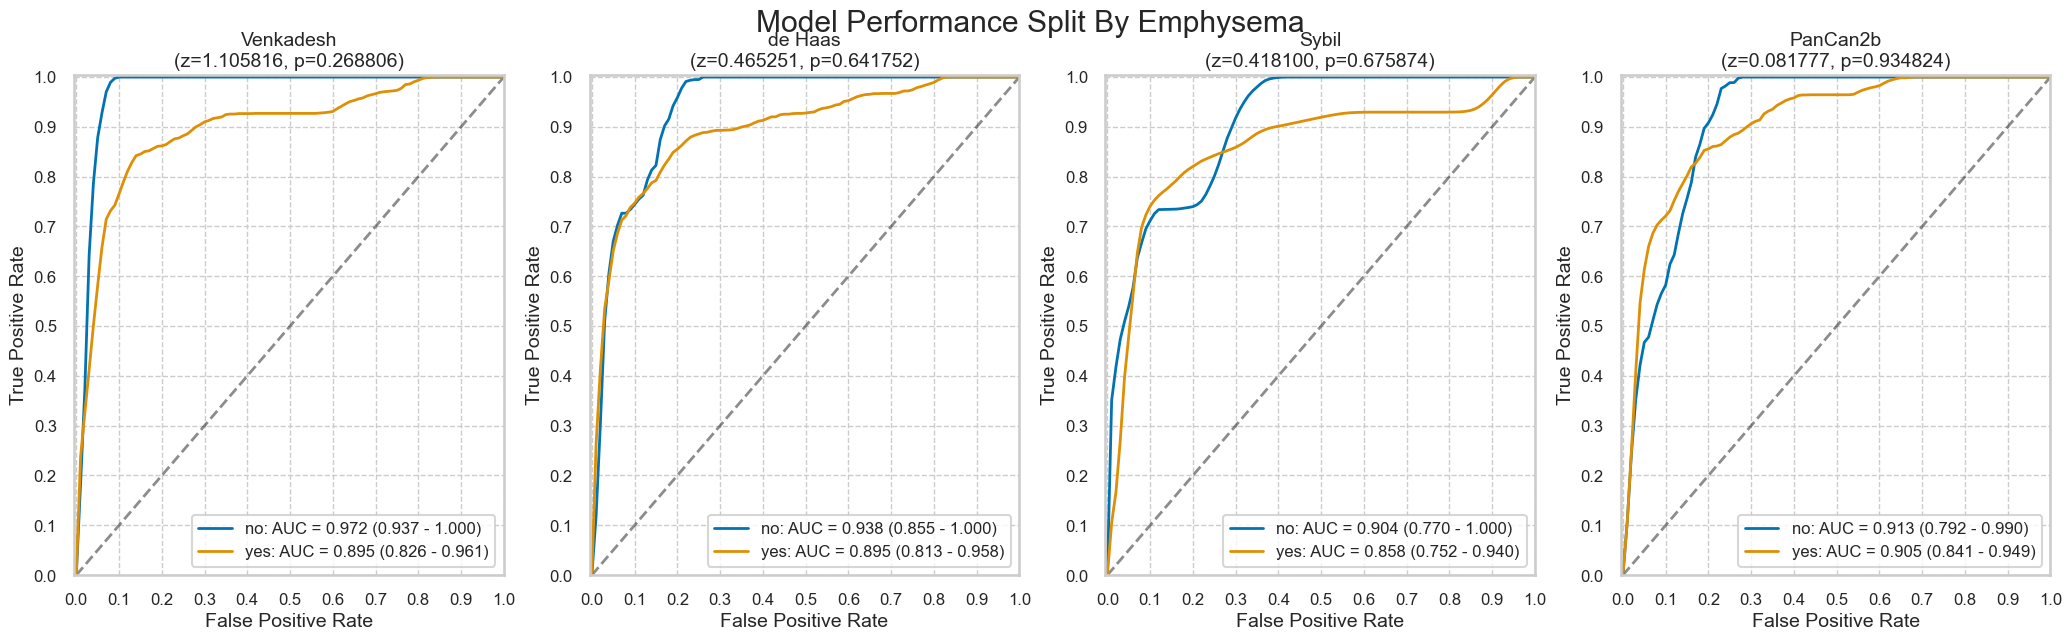

Venkadesh   de Haas     Sybil  PanCan2b
z   1.105816  0.465251  0.418100  0.081777
p   0.268806  0.641752  0.675874  0.934824

##### Sex = female

#### Emphysema

num        pct  num_mal    pct_mal
no    97  35.144928       11  11.340206
yes  179  64.855072       16   8.938547

Venkadesh


num  tp  fp   tn  fn  tpr       fpr  fnr       tnr       ppv  npv  \
no    97  11  22   64   0  1.0  0.255814  0.0  0.744186  0.333333  1.0   
yes  179  16  61  102   0  1.0  0.374233  0.0  0.625767  0.207792  1.0   

          fdr  for       acc         j        f1       mcc  
no   0.666667  0.0  0.773196  0.744186  0.500000  0.498058  
yes  0.792208  0.0  0.659218  0.625767  0.344086  0.360596

de Haas


num  tp   fp  tn  fn  tpr       fpr  fnr       tnr       ppv  npv  \
no    97  11   57  29   0  1.0  0.662791  0.0  0.337209  0.161765  1.0   
yes  179  16  117  46   0  1.0  0.717791  0.0  0.282209  0.120301  1.0   

          fdr  for       acc         j        f1       mcc  
no   0.838235  0.0  0.412371  0.337209  0.278481  0.233556  
yes  0.879699  0.0  0.346369  0.282209  0.214765  0.184255

Sybil


num  tp  fp   tn  fn       tpr       fpr       fnr       tnr       ppv  \
no    97   7   6   80   4  0.636364  0.069767  0.363636  0.930233  0.538462   
yes  179  10  29  134   6  0.625000  0.177914  0.375000  0.822086  0.256410   

          npv       fdr       for       acc         j        f1       mcc  
no   0.952381  0.461538  0.047619  0.896907  0.566596  0.583333  0.527361  
yes  0.957143  0.743590  0.042857  0.804469  0.447086  0.363636  0.308993

PanCan2b


num  tp  fp  tn  fn     tpr       fpr     fnr       tnr       ppv  \
no    97  11  28  58   0  1.0000  0.325581  0.0000  0.674419  0.282051   
yes  179  15  81  82   1  0.9375  0.496933  0.0625  0.503067  0.156250   

          npv       fdr       for       acc         j        f1       mcc  
no   1.000000  0.717949  0.000000  0.711340  0.674419  0.440000  0.436143  
yes  0.987952  0.843750  0.012048  0.541899  0.440567  0.267857  0.252053

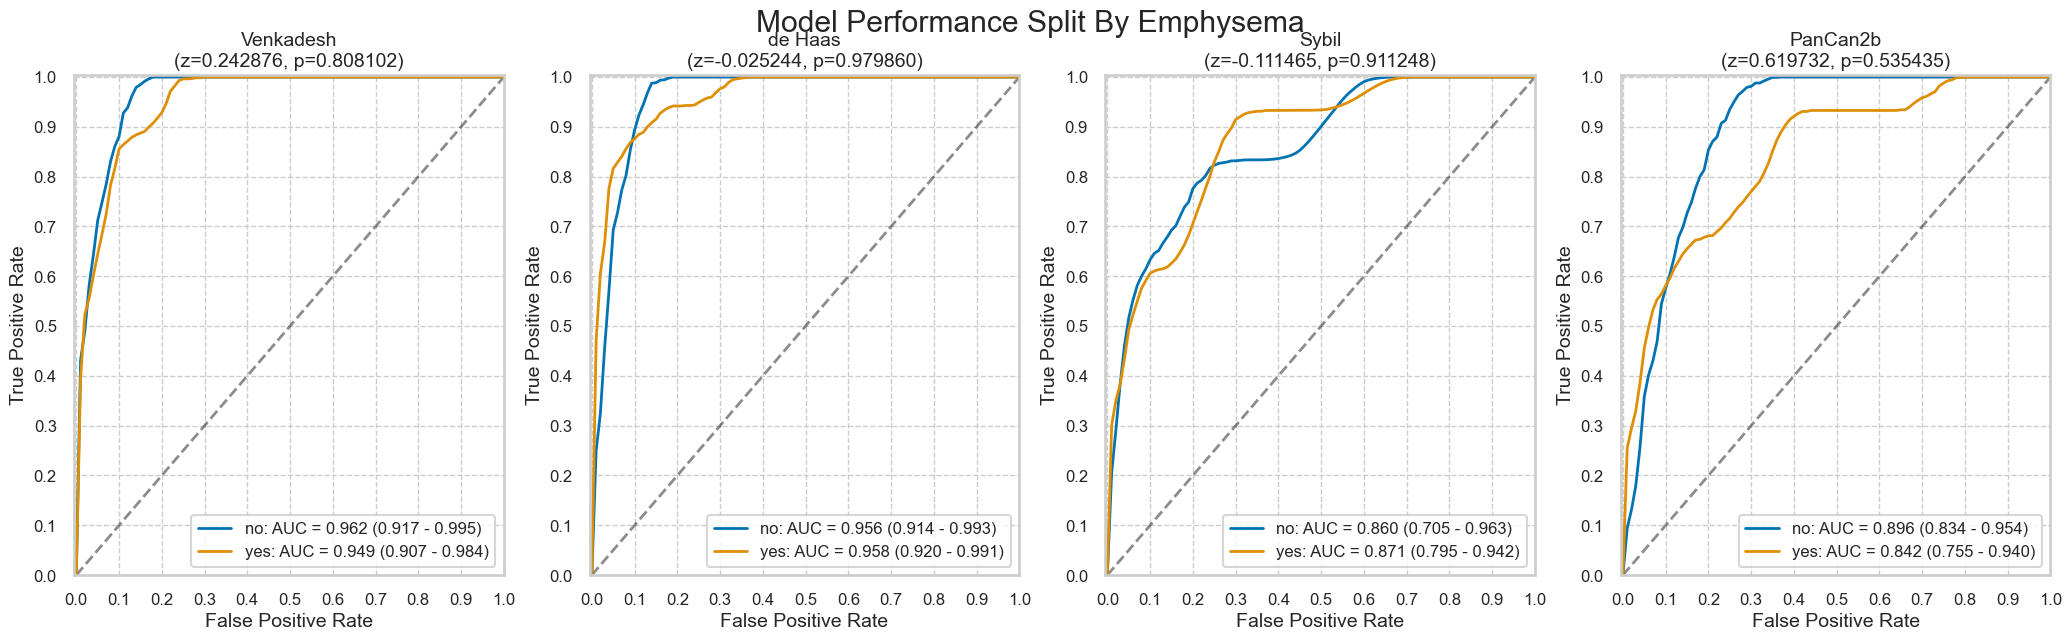

Venkadesh   de Haas     Sybil  PanCan2b
z   0.242876 -0.025244 -0.111465  0.619732
p   0.808102  0.979860  0.911248  0.535435

##### Sex = male

#### Age

num        pct  num_mal    pct_mal
50-62  221  68.421053        8   3.619910
62+    102  31.578947       24  23.529412

Venkadesh


num  tp  fp   tn  fn       tpr       fpr       fnr       tnr       ppv  \
50-62  221   7  39  174   1  0.875000  0.183099  0.125000  0.816901  0.152174   
62+    102  22  23   55   2  0.916667  0.294872  0.083333  0.705128  0.488889   

            npv       fdr       for       acc         j        f1       mcc  
50-62  0.994286  0.847826  0.005714  0.819005  0.691901  0.259259  0.318333  
62+    0.964912  0.511111  0.035088  0.754902  0.621795  0.637681  0.531198

de Haas


num  tp   fp  tn  fn    tpr       fpr    fnr       tnr       ppv  \
50-62  221   7  135  78   1  0.875  0.633803  0.125  0.366197  0.049296   
62+    102  24   55  23   0  1.000  0.705128  0.000  0.294872  0.303797   

            npv       fdr       for       acc         j        f1       mcc  
50-62  0.987342  0.950704  0.012658  0.384615  0.241197  0.093333  0.094005  
62+    1.000000  0.696203  0.000000  0.460784  0.294872  0.466019  0.299301

Sybil


num  tp  fp   tn  fn   tpr       fpr   fnr       tnr       ppv  \
50-62  221   6  14  199   2  0.75  0.065728  0.25  0.934272  0.300000   
62+    102  18  10   68   6  0.75  0.128205  0.25  0.871795  0.642857   

            npv       fdr       for       acc         j        f1       mcc  
50-62  0.990050  0.700000  0.009950  0.927602  0.684272  0.428571  0.445503  
62+    0.918919  0.357143  0.081081  0.843137  0.621795  0.692308  0.591024

PanCan2b


num  tp  fp   tn  fn       tpr       fpr       fnr       tnr       ppv  \
50-62  221   7  49  164   1  0.875000  0.230047  0.125000  0.769953  0.125000   
62+    102  22  29   49   2  0.916667  0.371795  0.083333  0.628205  0.431373   

            npv       fdr       for       acc         j        f1       mcc  
50-62  0.993939  0.875000  0.006061  0.773756  0.644953  0.218750  0.276966  
62+    0.960784  0.568627  0.039216  0.696078  0.544872  0.586667  0.462250

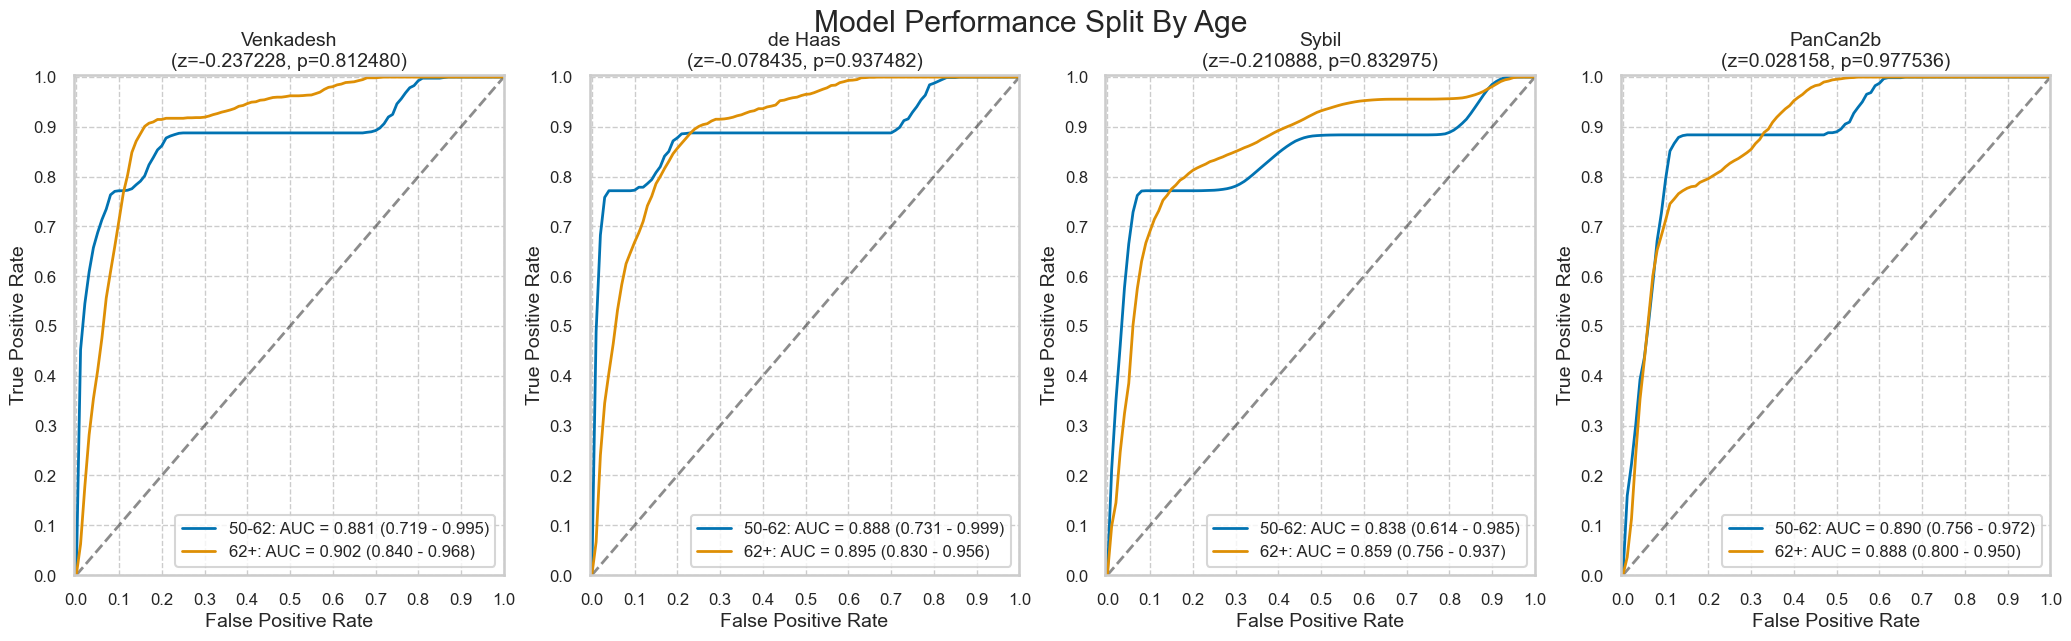

Venkadesh   de Haas     Sybil  PanCan2b
z  -0.237228 -0.078435 -0.210888  0.028158
p   0.812480  0.937482  0.832975  0.977536

##### Sex = female

#### Age

num        pct  num_mal    pct_mal
50-62  214  77.536232       20   9.345794
62+     62  22.463768        7  11.290323

Venkadesh


num  tp  fp   tn  fn  tpr       fpr  fnr       tnr       ppv  npv  \
50-62  214  20  66  128   0  1.0  0.340206  0.0  0.659794  0.232558  1.0   
62+     62   7  17   38   0  1.0  0.309091  0.0  0.690909  0.291667  1.0   

            fdr  for       acc         j        f1       mcc  
50-62  0.767442  0.0  0.691589  0.659794  0.377358  0.391715  
62+    0.708333  0.0  0.725806  0.690909  0.451613  0.448904

de Haas


num  tp   fp  tn  fn  tpr       fpr  fnr       tnr       ppv  npv  \
50-62  214  20  136  58   0  1.0  0.701031  0.0  0.298969  0.128205  1.0   
62+     62   7   38  17   0  1.0  0.690909  0.0  0.309091  0.155556  1.0   

            fdr  for       acc         j        f1       mcc  
50-62  0.871795  0.0  0.364486  0.298969  0.227273  0.195779  
62+    0.844444  0.0  0.387097  0.309091  0.269231  0.219273

Sybil


num  tp  fp   tn  fn       tpr       fpr       fnr       tnr       ppv  \
50-62  214  12  25  169   8  0.600000  0.128866  0.400000  0.871134  0.324324   
62+     62   5  10   45   2  0.714286  0.181818  0.285714  0.818182  0.333333   

            npv       fdr       for       acc         j        f1       mcc  
50-62  0.954802  0.675676  0.045198  0.845794  0.471134  0.421053  0.362638  
62+    0.957447  0.666667  0.042553  0.806452  0.532468  0.454545  0.393486

PanCan2b


num  tp  fp   tn  fn       tpr       fpr       fnr       tnr       ppv  \
50-62  214  20  85  109   0  1.000000  0.438144  0.000000  0.561856  0.190476   
62+     62   6  24   31   1  0.857143  0.436364  0.142857  0.563636  0.200000   

           npv       fdr      for       acc         j        f1       mcc  
50-62  1.00000  0.809524  0.00000  0.602804  0.561856  0.320000  0.327139  
62+    0.96875  0.800000  0.03125  0.596774  0.420779  0.324324  0.266470

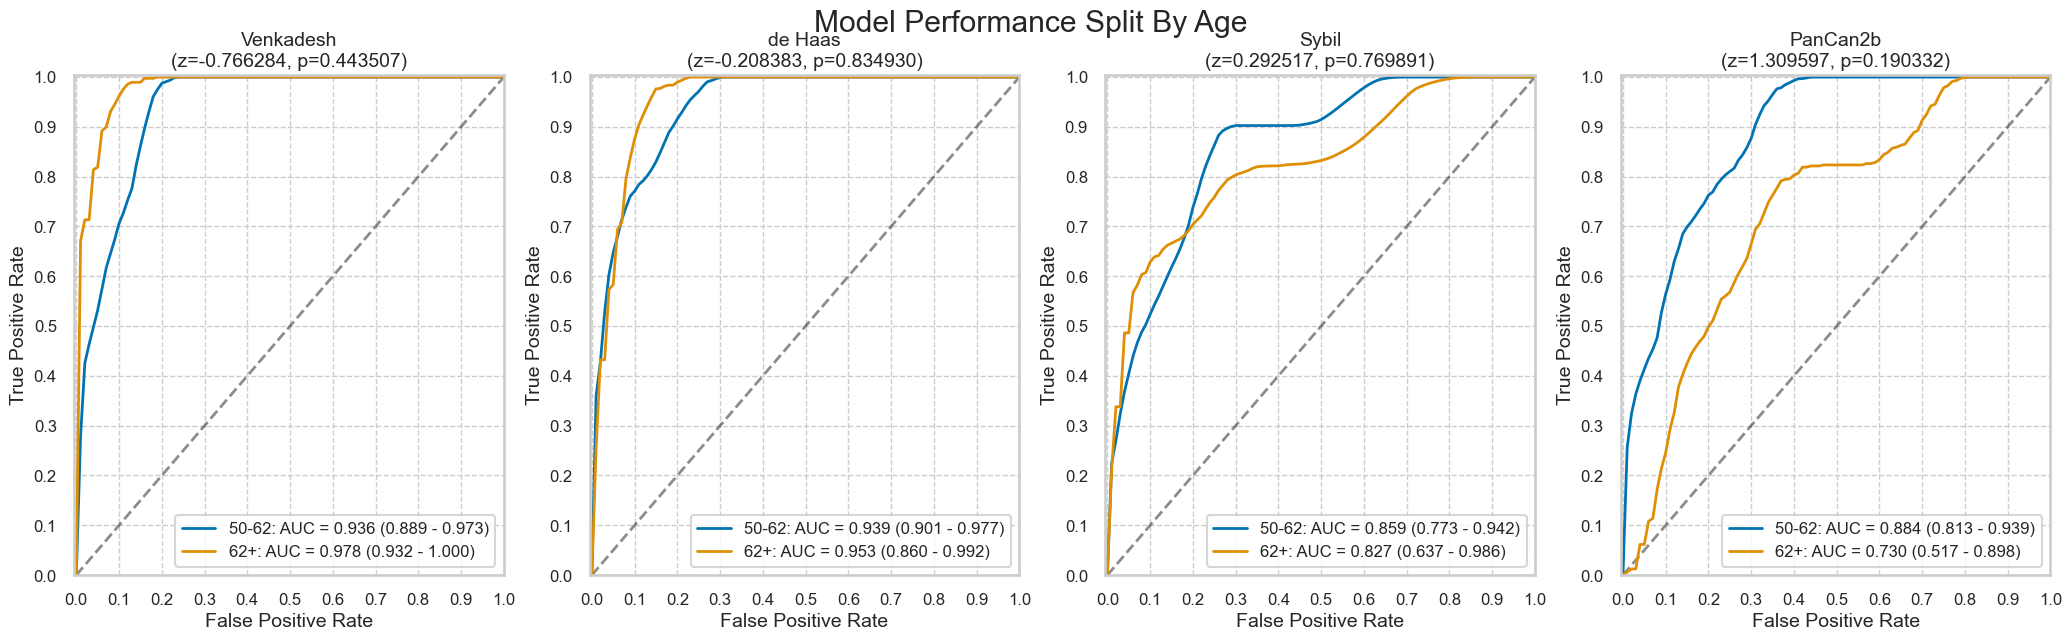

Venkadesh   de Haas     Sybil  PanCan2b
z  -0.766284 -0.208383  0.292517  1.309597
p   0.443507  0.834930  0.769891  0.190332

##### Sex = male

#### NoduleCountPerScan

num        pct  num_mal    pct_mal
1   176  54.489164       20  11.363636
>1  147  45.510836       12   8.163265

Venkadesh


num  tp  fp   tn  fn       tpr       fpr       fnr       tnr       ppv  \
1   176  18  31  125   2  0.900000  0.198718  0.100000  0.801282  0.367347   
>1  147  11  31  104   1  0.916667  0.229630  0.083333  0.770370  0.261905   

         npv       fdr       for       acc         j        f1       mcc  
1   0.984252  0.632653  0.015748  0.812500  0.701282  0.521739  0.496558  
>1  0.990476  0.738095  0.009524  0.782313  0.687037  0.407407  0.416407

de Haas


num  tp  fp  tn  fn   tpr       fpr   fnr       tnr       ppv       npv  \
1   176  19  99  57   1  0.95  0.634615  0.05  0.365385  0.161017  0.982759   
>1  147  12  91  44   0  1.00  0.674074  0.00  0.325926  0.116505  1.000000   

         fdr       for       acc         j        f1       mcc  
1   0.838983  0.017241  0.431818  0.315385  0.275362  0.212943  
>1  0.883495  0.000000  0.380952  0.325926  0.208696  0.194864

Sybil


num  tp  fp   tn  fn       tpr       fpr       fnr       tnr       ppv  \
1   176  16  11  145   4  0.800000  0.070513  0.200000  0.929487  0.592593   
>1  147   8  13  122   4  0.666667  0.096296  0.333333  0.903704  0.380952   

         npv       fdr       for       acc         j        f1       mcc  
1   0.973154  0.407407  0.026846  0.914773  0.729487  0.680851  0.642421  
>1  0.968254  0.619048  0.031746  0.884354  0.570370  0.484848  0.446292

PanCan2b


num  tp  fp   tn  fn       tpr       fpr       fnr       tnr       ppv  \
1   176  19  42  114   1  0.950000  0.269231  0.050000  0.730769  0.311475   
>1  147  10  36   99   2  0.833333  0.266667  0.166667  0.733333  0.217391   

         npv       fdr       for       acc         j        f1       mcc  
1   0.991304  0.688525  0.008696  0.755682  0.680769  0.469136  0.454008  
>1  0.980198  0.782609  0.019802  0.741497  0.566667  0.344828  0.334615

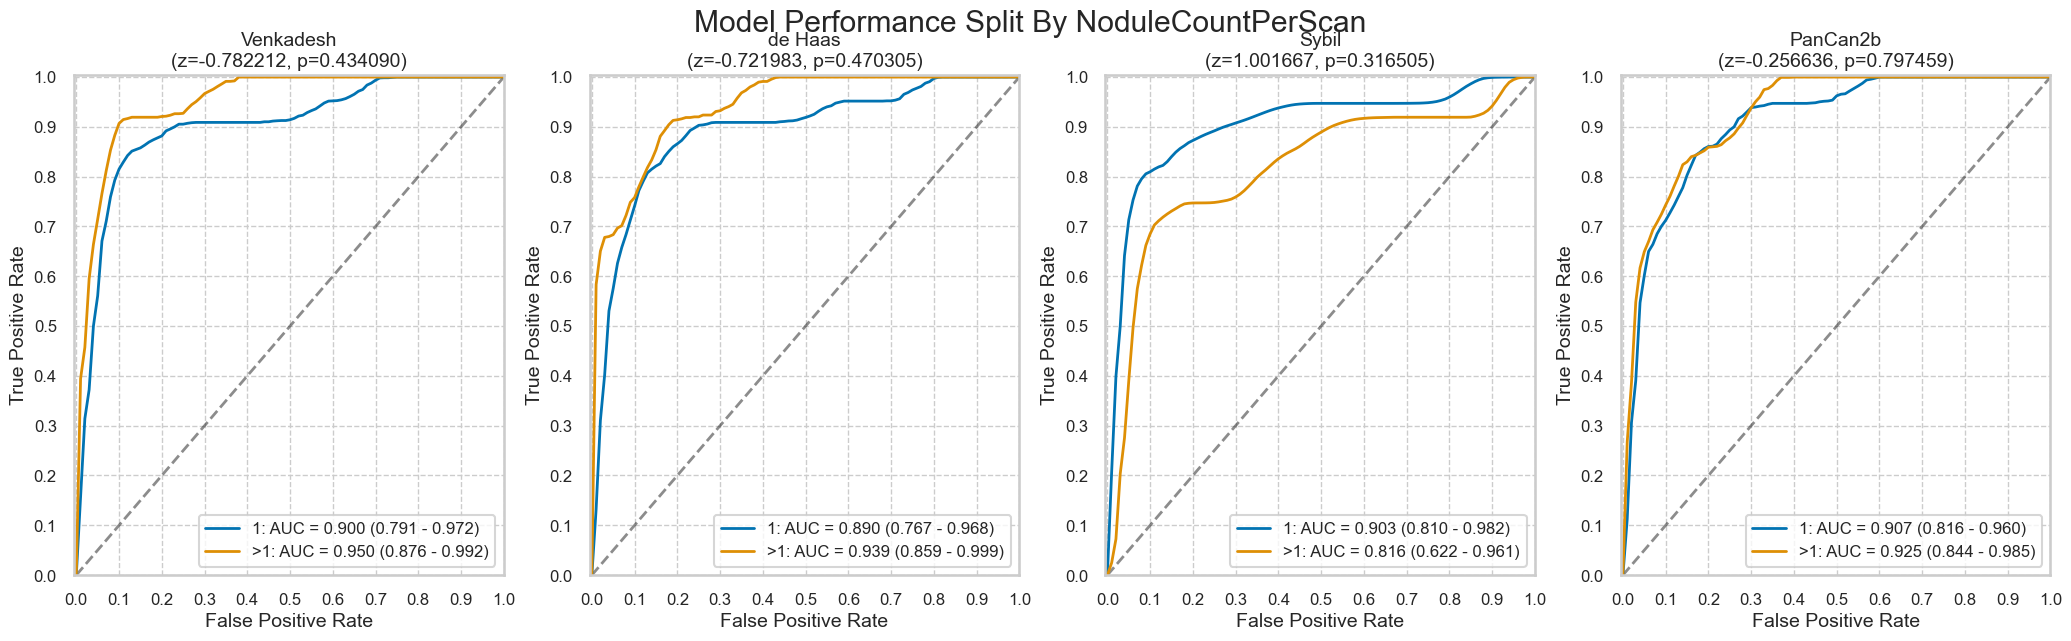

Venkadesh   de Haas     Sybil  PanCan2b
z  -0.782212 -0.721983  1.001667 -0.256636
p   0.434090  0.470305  0.316505  0.797459

##### Sex = female

#### NoduleCountPerScan

num        pct  num_mal    pct_mal
1   157  56.884058       15   9.554140
>1  119  43.115942       12  10.084034

Venkadesh


num  tp  fp   tn  fn  tpr       fpr  fnr       tnr       ppv  npv  \
1   157  15  36  106   0  1.0  0.253521  0.0  0.746479  0.294118  1.0   
>1  119  12  47   60   0  1.0  0.439252  0.0  0.560748  0.203390  1.0   

         fdr  for       acc         j        f1       mcc  
1   0.705882  0.0  0.770701  0.746479  0.454545  0.468564  
>1  0.796610  0.0  0.605042  0.560748  0.338028  0.337713

de Haas


num  tp  fp  tn  fn  tpr       fpr  fnr       tnr       ppv  npv  \
1   157  15  96  46   0  1.0  0.676056  0.0  0.323944  0.135135  1.0   
>1  119  12  78  29   0  1.0  0.728972  0.0  0.271028  0.133333  1.0   

         fdr  for       acc         j        f1       mcc  
1   0.864865  0.0  0.388535  0.323944  0.238095  0.209228  
>1  0.866667  0.0  0.344538  0.271028  0.235294  0.190098

Sybil


num  tp  fp   tn  fn       tpr       fpr       fnr       tnr       ppv  \
1   157  11  15  127   4  0.733333  0.105634  0.266667  0.894366  0.423077   
>1  119   6  20   87   6  0.500000  0.186916  0.500000  0.813084  0.230769   

         npv       fdr       for       acc         j        f1       mcc  
1   0.969466  0.576923  0.030534  0.878981  0.627700  0.536585  0.496386  
>1  0.935484  0.769231  0.064516  0.781513  0.313084  0.315789  0.228147

PanCan2b


num  tp  fp  tn  fn       tpr       fpr       fnr       tnr       ppv  \
1   157  15  56  86   0  1.000000  0.394366  0.000000  0.605634  0.211268   
>1  119  11  53  54   1  0.916667  0.495327  0.083333  0.504673  0.171875   

         npv       fdr       for       acc         j        f1       mcc  
1   1.000000  0.788732  0.000000  0.643312  0.605634  0.348837  0.357702  
>1  0.981818  0.828125  0.018182  0.546218  0.421340  0.289474  0.254474

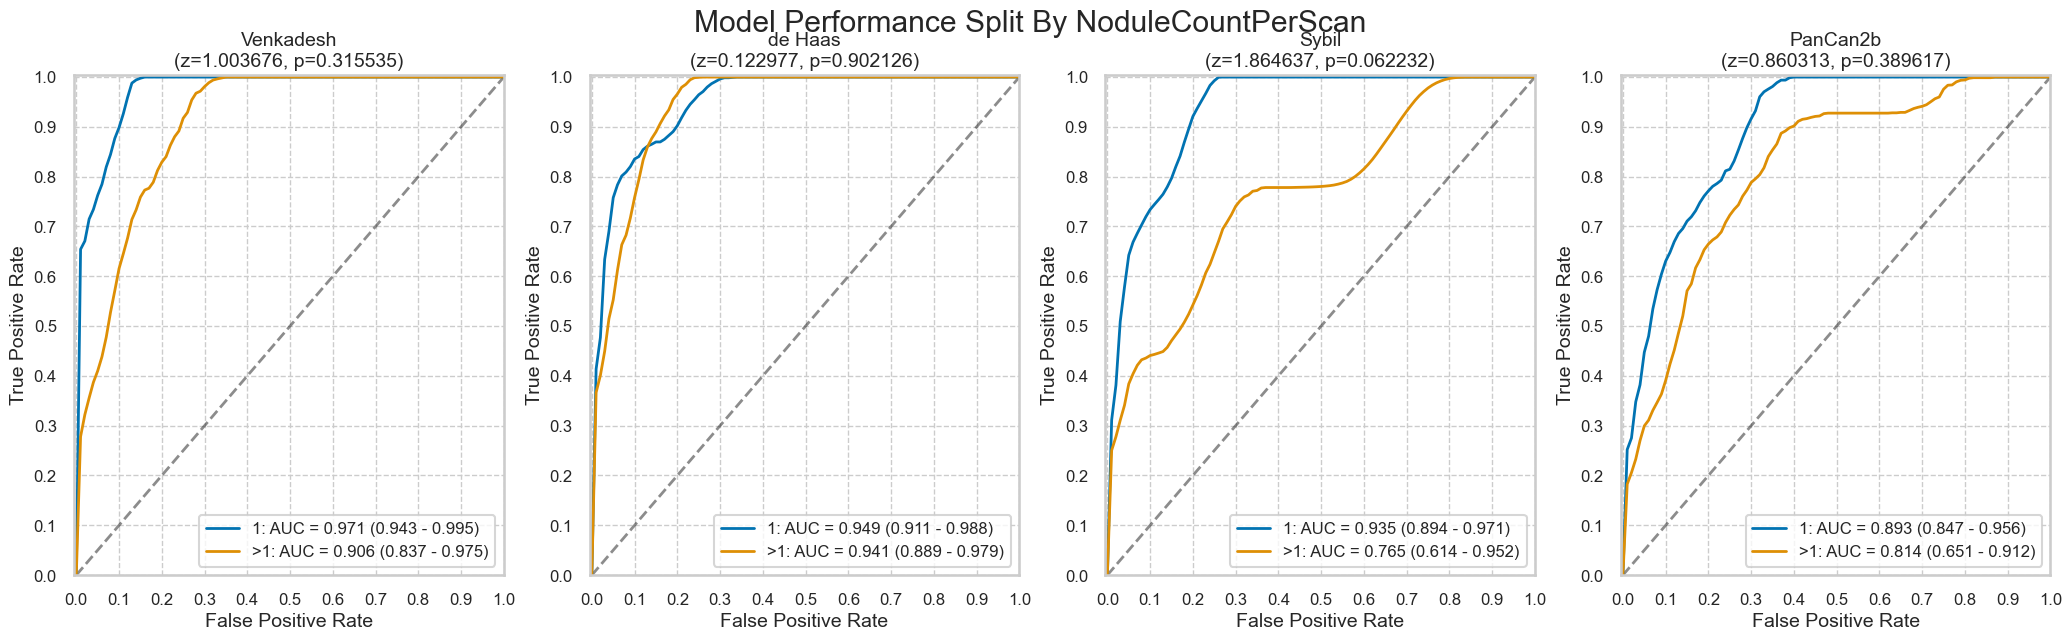

Venkadesh   de Haas     Sybil  PanCan2b
z   1.003676  0.122977  1.864637  0.860313
p   0.315535  0.902126  0.062232  0.389617

In [29]:
for q in SPLIT_QUERIES:
    if q == SPLIT_CAT: continue
    for val in split_groups:
        df = split_groups[val]
        display(Markdown(f"##### {SPLIT_CAT} = {val}"))
        rocs_splits(df, q)